In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np

In [7]:
train = pd.read_csv('/content/drive/MyDrive/Thesis/Data/Filled Datasets/Second dataset (Kaggle)/Preprocessed/combined_train_val.csv',header=0)
test = pd.read_csv('/content/drive/MyDrive/Thesis/Data/Filled Datasets/Second dataset (Kaggle)/Preprocessed/Constraint_Test_fullprep_with_labels.csv')
print(train.head(n=3))
print(test.head(n=3))

                                               tweet  label
0  cdc currently reports deaths general discrepan...      0
1  states reported deaths small rise last tuesday...      0
2  politically correct woman almost uses pandemic...      1
   id                                              tweet  label
0   1  daily update published states reported k tests...      0
1   2                                 alfalfa cure covid      1
2   3      president trump asked would catch coronavirus      1


In [8]:
Xtrain = train['tweet']
Ytrain = train['label']
Xtest = test['tweet']
Ytest = test['label']

In [9]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc
# Create the confussion matrix
def plot_confussion_matrix(y_test, y_pred):
    ''' Plot the confussion matrix for the target labels and predictions '''
    cm = confusion_matrix(y_test, y_pred)

    # Create a dataframe with the confussion matrix values
    df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))
    #plt.figure(figsize = (10,7))
    # Plot the confussion matrix
    sn.set(font_scale=1.4) #for label size
    sn.heatmap(df_cm, annot=True,fmt='.0f',annot_kws={"size": 10})# font size
    plt.show()
    
# ROC Curve
# plot no skill
# Calculate the points in the ROC curve
def plot_roc_curve(y_test, y_pred):
    ''' Plot the ROC curve for the target labels and predictions'''
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc= auc(fpr,tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

tf = CountVectorizer()

X_train_tf = tf.fit_transform(Xtrain)
# transform the test set with vectoriser
X_test_tf = tf.transform(Xtest)

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

tf_bi = CountVectorizer(ngram_range=(2,2))

X_train_tf_bi = tf_bi.fit_transform(Xtrain)
# transform the test set with vectoriser
X_test_tf_bi = tf_bi.transform(Xtest)

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf=TfidfVectorizer()

# transform and fit the training set with vectoriser
X_train_tfidf = tfidf.fit_transform(Xtrain)
# transform the test set with vectoriser
X_test_tfidf = tfidf.transform(Xtest)

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_bi=TfidfVectorizer(ngram_range=(2,2))

# transform and fit the training set with vectoriser
X_train_tfidf_bi = tfidf_bi.fit_transform(Xtrain)
# transform the test set with vectoriser
X_test_tfidf_bi = tfidf_bi.transform(Xtest)

We'll train Logistic Regression for several settings:

- TF (BOW:) with both uni- and bigrams
- TF-IDF with both uni- and bigrams

We'll each time apply grid search. 

We'll apply and visualize grid search to class weights, and select appropriate weights based on the graph

In [3]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import seaborn as sns
lr = LogisticRegression()

#Setting the range for class weights
weights = np.linspace(0.1,0.9,9)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1-x} for x in weights]}

#Fitting grid search to the train data with 5 folds


BOW unigram with grid search

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Scoring for different class weights')

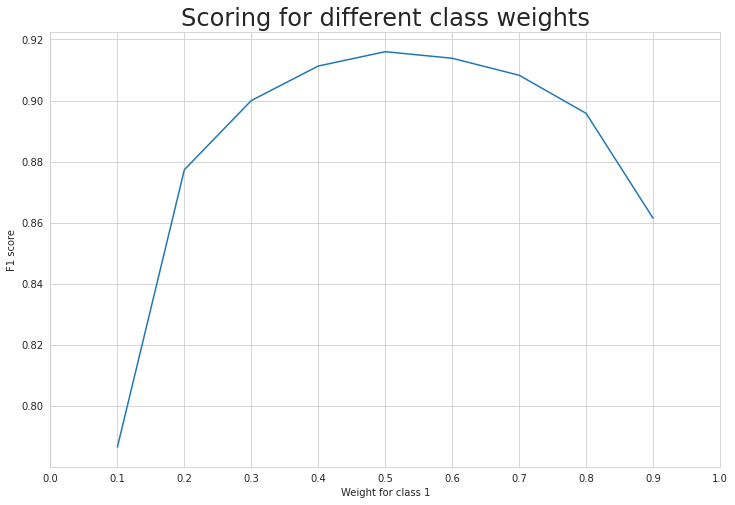

In [12]:
lr_grid = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train_tf,Ytrain)

import matplotlib.pyplot as plt
#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': lr_grid.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)

In [13]:
lr_tf = LogisticRegression(class_weight = {1: 0.5, 0:0.5})
lr_tf.fit(X_train_tf,Ytrain)
print("train score:", lr_tf.score(X_train_tf, Ytrain))
print("test score:", lr_tf.score(X_test_tf, Ytest))

y_pred = lr_tf.predict(X_test_tf)
print(metrics.classification_report(Ytest, y_pred,  digits=5))
print(confusion_matrix(Ytest,y_pred))

train score: 0.9756952559009114
test score: 0.9177185600748013
              precision    recall  f1-score   support

           0    0.93536   0.90527   0.92007      1119
           1    0.89962   0.93137   0.91522      1020

    accuracy                        0.91772      2139
   macro avg    0.91749   0.91832   0.91765      2139
weighted avg    0.91832   0.91772   0.91776      2139

[[1013  106]
 [  70  950]]


Let's quickly check whether scoring for precision leads to better performance: 

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Scoring for different class weights')

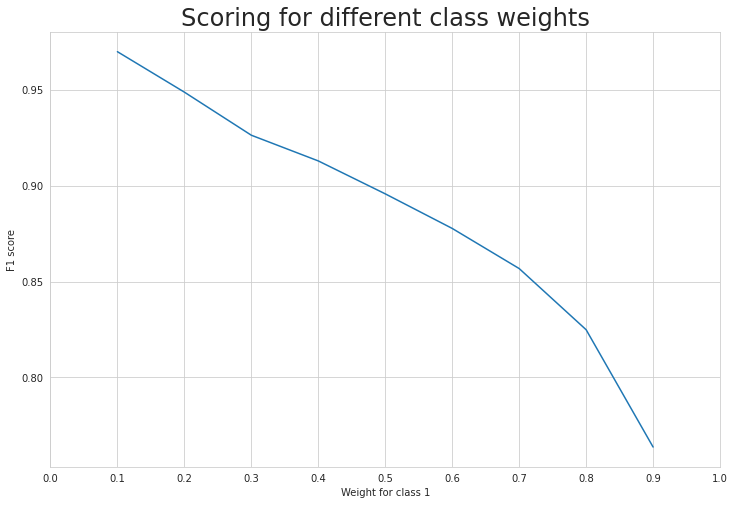

In [27]:
lr_grid = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='precision', 
                          verbose=2).fit(X_train_tf,Ytrain)

import matplotlib.pyplot as plt
#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': lr_grid.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('Precision')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)

In [28]:
lr_tf = LogisticRegression(class_weight = {1: 0.1, 0:0.9})
lr_tf.fit(X_train_tf,Ytrain)
print("train score:", lr_tf.score(X_train_tf, Ytrain))
print("test score:", lr_tf.score(X_test_tf, Ytest))

y_pred = lr_tf.predict(X_test_tf)
print(metrics.classification_report(Ytest, y_pred,  digits=5))
print(confusion_matrix(Ytest,y_pred))

train score: 0.8829165692918907
test score: 0.8588125292192613
              precision    recall  f1-score   support

           0    0.79325   0.98749   0.87978      1119
           1    0.98123   0.71765   0.82899      1020

    accuracy                        0.85881      2139
   macro avg    0.88724   0.85257   0.85438      2139
weighted avg    0.88289   0.85881   0.85556      2139

[[1105   14]
 [ 288  732]]


Yes, but we sacrify much in fake class recall and overall accuracy. we're also quite unprecise on the real class precision, which is also important.

So let's continue using f1 score as metric.

BOW bigram with grid search 

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Scoring for different class weights')

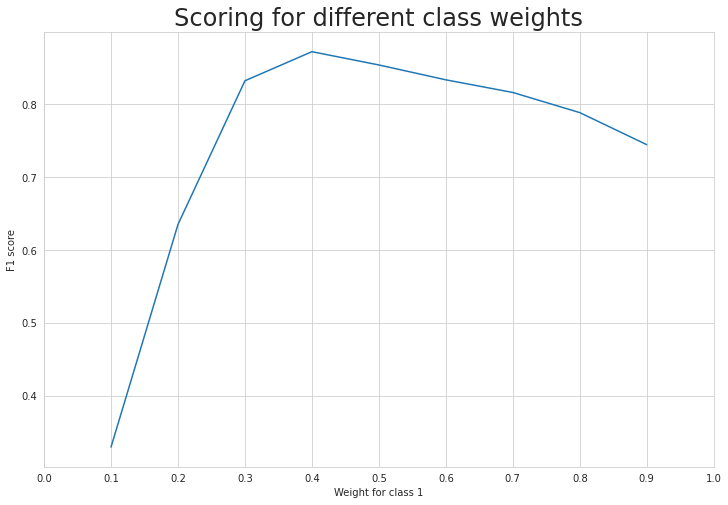

In [16]:
lr_grid_bi = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train_tf_bi,Ytrain)

import matplotlib.pyplot as plt
#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': lr_grid_bi.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)

In [19]:
lr_tf_bi = LogisticRegression(class_weight = {1: 0.4, 0:0.6})
lr_tf_bi.fit(X_train_tf_bi,Ytrain)
print("train score:", lr_tf_bi.score(X_train_tf_bi, Ytrain))
print("test score:", lr_tf_bi.score(X_test_tf_bi, Ytest))

y_pred = lr_tf_bi.predict(X_test_tf_bi)
print(metrics.classification_report(Ytest, y_pred,  digits=5))
print(confusion_matrix(Ytest,y_pred))

train score: 0.9980135545688245
test score: 0.8737727910238429
              precision    recall  f1-score   support

           0    0.94173   0.80876   0.87019      1119
           1    0.81834   0.94510   0.87716      1020

    accuracy                        0.87377      2139
   macro avg    0.88003   0.87693   0.87368      2139
weighted avg    0.88289   0.87377   0.87352      2139

[[905 214]
 [ 56 964]]


TFIDF unigram with grid search

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Scoring for different class weights')

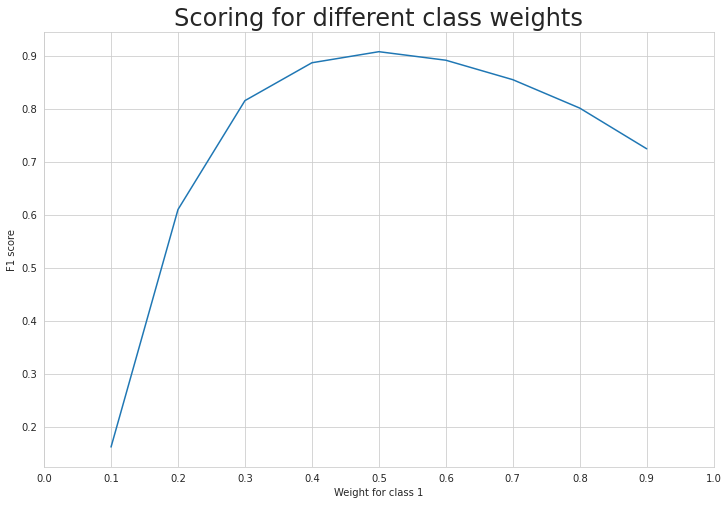

In [21]:
lr_grid_tfidf = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train_tfidf,Ytrain)

import matplotlib.pyplot as plt
#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': lr_grid_tfidf.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)

In [22]:
lr_tfidf = LogisticRegression(class_weight = {1: 0.5, 0:0.5})
lr_tfidf.fit(X_train_tfidf,Ytrain)
print("train score:", lr_tfidf.score(X_train_tfidf, Ytrain))
print("test score:", lr_tfidf.score(X_test_tfidf, Ytest))

y_pred = lr_tfidf.predict(X_test_tfidf)
print(metrics.classification_report(Ytest, y_pred,  digits=5))
print(confusion_matrix(Ytest,y_pred))

train score: 0.9398223884085066
test score: 0.9130434782608695
              precision    recall  f1-score   support

           0    0.93803   0.89276   0.91484      1119
           1    0.88827   0.93529   0.91117      1020

    accuracy                        0.91304      2139
   macro avg    0.91315   0.91403   0.91300      2139
weighted avg    0.91430   0.91304   0.91309      2139

[[999 120]
 [ 66 954]]


TFIDF bigram with grid search

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Scoring for different class weights')

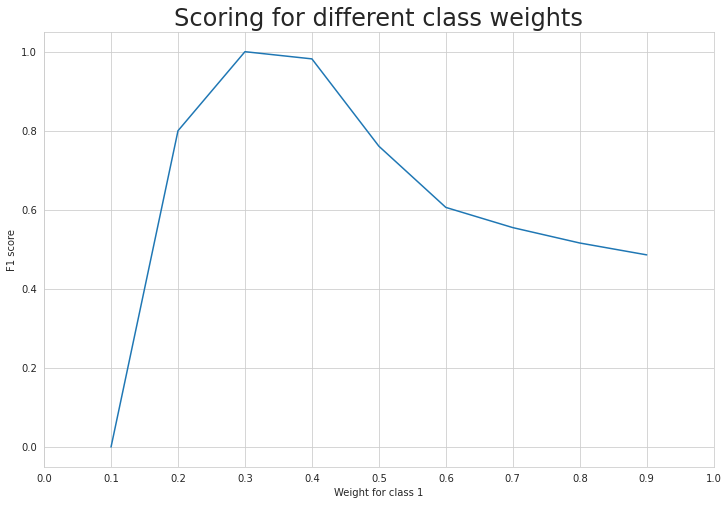

In [26]:
lr_grid_tfidf_bi = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train_tfidf_bi,Ytrain)

import matplotlib.pyplot as plt
#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': lr_grid_tfidf_bi.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)

In [25]:
lr_tfidf_bi = LogisticRegression(class_weight = {1: 0.5, 0:0.5})
lr_tfidf_bi.fit(X_train_tfidf_bi,Ytrain)
print("train score:", lr_tfidf_bi.score(X_train_tfidf_bi, Ytrain))
print("test score:", lr_tfidf_bi.score(X_test_tfidf_bi, Ytest))

y_pred = lr_tfidf_bi.predict(X_test_tfidf_bi)
print(metrics.classification_report(Ytest, y_pred,  digits=5))
print(confusion_matrix(Ytest,y_pred))

train score: 0.9874970787567189
test score: 0.8719027582982702
              precision    recall  f1-score   support

           0    0.93245   0.81412   0.86927      1119
           1    0.82100   0.93529   0.87443      1020

    accuracy                        0.87190      2139
   macro avg    0.87672   0.87471   0.87185      2139
weighted avg    0.87930   0.87190   0.87173      2139

[[911 208]
 [ 66 954]]


**EXPLAINABILITY THROUGH LIME**

We'll do this for the optimal model (i.e. TF unigram)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf=TfidfVectorizer()

# transform and fit the training set with vectoriser
X_train_tfidf = tfidf.fit_transform(Xtrain)
# transform the test set with vectoriser
X_test_tfidf = tfidf.transform(Xtest)

In [ ]:
pip install lime

     |████████████████████████████████| 275 kB 7.2 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=347515c4ddaa93fa8667b803cf7b4d343341b913ed2f9770420be6810321dc23
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
# importing the libraries
import lime
import sklearn.ensemble
from __future__ import print_function
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

# converting the vectoriser and model into a pipeline
# this is necessary as LIME takes a model pipeline as an input
c = make_pipeline(tfidf, nb_tfidf)

# saving a list of strings version of the X_test object
ls_X_test= list(Xtest)

# saving the class names in a dictionary to increase interpretability
class_names = {0: 'Real', 1:'Fake'}

In [ ]:
index = ls_X_test.index('chinese medical supplies ghana contaminated coronavirus')

In [ ]:
# create the LIME explainer
# add the class names for interpretability
LIME_explainer = LimeTextExplainer(class_names=class_names)

# choose a random single prediction
idx = index
# explain the chosen prediction 
# use the probability results of the logistic regression
# can also add num_features parameter to reduce the number of features explained
LIME_exp = LIME_explainer.explain_instance(ls_X_test[idx], c.predict_proba)
# print results
print('Document id: %d' % idx)
print('Tweet: ', ls_X_test[idx])
print('Probability fake news =', c.predict_proba([ls_X_test[idx]]).round(3)[0,1])
print('True class: %s' % class_names.get(list(Ytest)[idx]))

Document id: 837
Tweet:  chinese medical supplies ghana contaminated coronavirus
Probability fake news = 0.985
True class: Fake


In [ ]:
# print class names to show what classes the viz refers to
print("1 = Fakenews, 0 = Realnews")
# show the explainability results with highlighted text
LIME_exp.show_in_notebook(text=True)

1 = Fakenews, 0 = Realnews
